# Logistic Regression Notebook


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import os


In [2]:
# Load dataset
bank_df = pd.read_csv(r'C:\Users\aryan\Desktop\XAI\XAI_Models\binary\bank_customer_churn\Bank Customer Churn Prediction.csv')

# Display basic info
print(bank_df.info())
print(bank_df.describe())
print(bank_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None
        customer_id  credit_score           age        tenure        balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean 

         customer_id  credit_score country gender           age        tenure  \
count   1.000000e+04  10000.000000   10000  10000  10000.000000  10000.000000   
unique           NaN           NaN       3      2           NaN           NaN   
top              NaN           NaN  France   Male           NaN           NaN   
freq             NaN           NaN    5014   5457           NaN           NaN   
mean    1.569094e+07    650.528800     NaN    NaN     38.921800      5.012800   
std     7.193619e+04     96.653299     NaN    NaN     10.487806      2.892174   
min     1.556570e+07    350.000000     NaN    NaN     18.000000      0.000000   
25%     1.562853e+07    584.000000     NaN    NaN     32.000000      3.000000   
50%     1.569074e+07    652.000000     NaN    NaN     37.000000      5.000000   
75%     1.575323e+07    718.000000     NaN    NaN     44.000000      7.000000   
max     1.581569e+07    850.000000     NaN    NaN     92.000000     10.000000   

              balance  prod

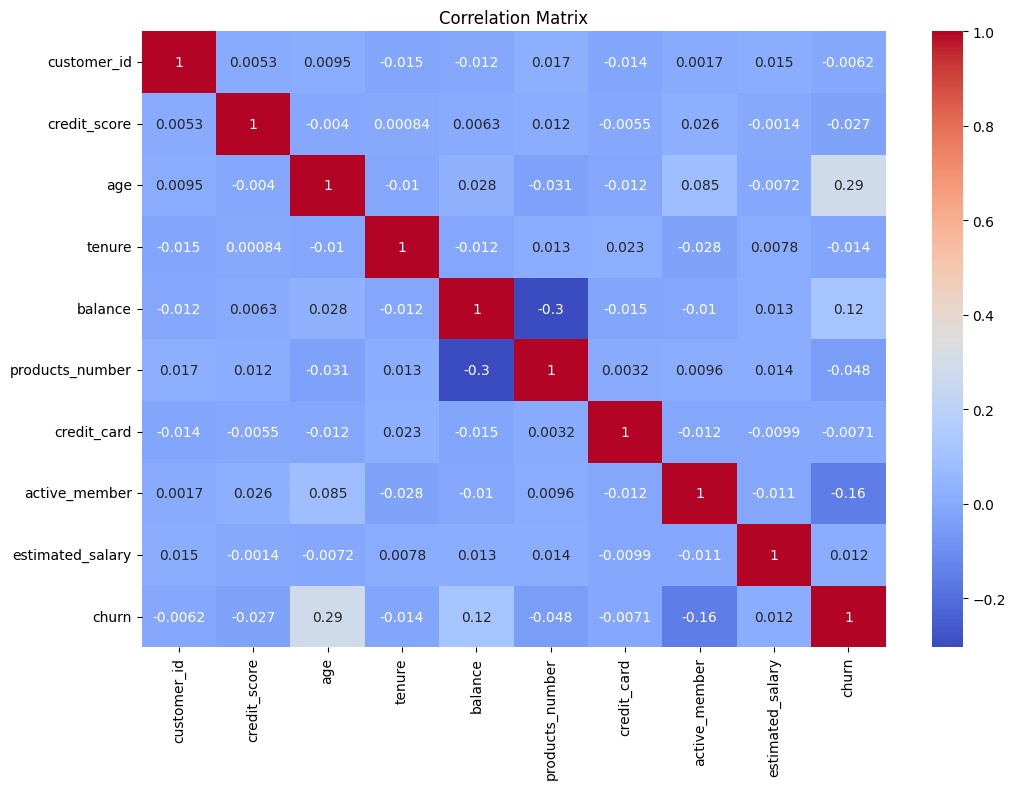

In [4]:
# Display basic statistics
print(bank_df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = bank_df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

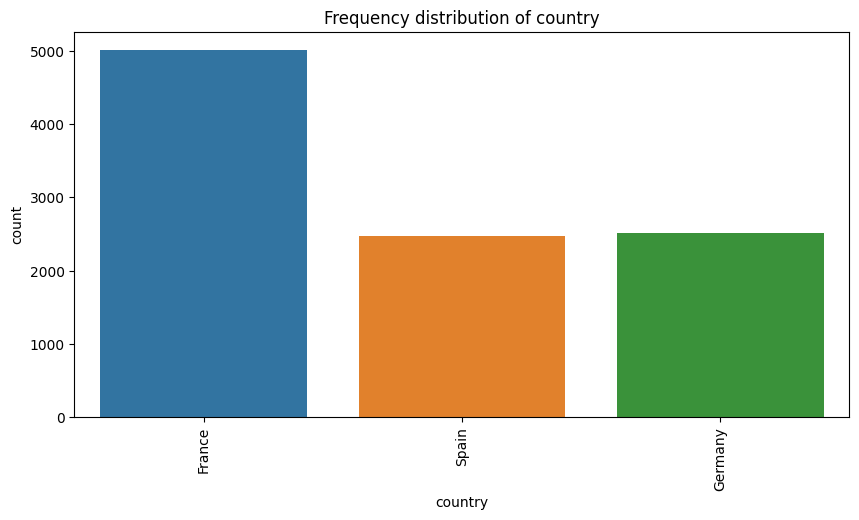

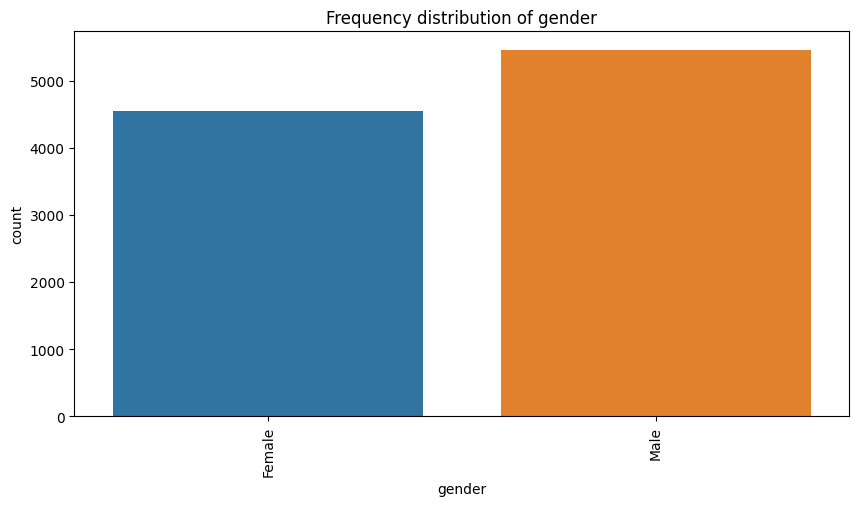

In [5]:
# Frequency distributions for categorical variables
categorical_columns = bank_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=bank_df, x=column)
    plt.title(f'Frequency distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

In [6]:

# Define the target and features
X = bank_df.drop(columns=['churn'])
y = bank_df['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:

# Define the preprocessor
numerical_features = bank_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = bank_df.select_dtypes(include=['object']).columns.tolist()
numerical_features.remove('churn')  # Remove the target column

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [8]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    # Create the model with the suggested hyperparameters
    lr_classifier = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        max_iter=1000
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', lr_classifier)
    ])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
    return scores.mean()

In [9]:
# Define the JSON file name
json_file = 'Logistic Regression.json'

def is_valid_hyperparameters(data):
    return isinstance(data, dict) and all(param in data for param in ['penalty', 'C', 'solver', 'max_iter'])

# Check if the JSON file exists
if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        best_params = json.load(file)
    
    # Validate the content of the JSON file
    if not is_valid_hyperparameters(best_params):
        print(f"Invalid content in {json_file}, regenerating hyperparameters...")
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        best_params = study.best_params
        
        # Save the valid hyperparameters to the JSON file
        with open(json_file, 'w') as file:
            json.dump(best_params, file)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    best_params = study.best_params

    # Save the hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


[I 2025-02-24 19:28:39,291] A new study created in memory with name: no-name-0c0d10cc-d80e-470e-a968-464e8c9686f7


Invalid content in Logistic Regression.json, regenerating hyperparameters...


C:\Users\aryan\AppData\Local\Temp\ipykernel_20308\3990527050.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-02-24 19:28:41,830] Trial 0 finished with value: 0.810125 and parameters: {'penalty': 'l2', 'C': 38.67546518953651, 'solver': 'liblinear', 'max_iter': 668}. Best is trial 0 with value: 0.810125.
C:\Users\aryan\AppData\Local\Temp\ipykernel_20308\3990527050.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-02-24 19:28:43,369] Trial 1 finished with value: 0.810125 and parameters: {'penalty': 'l2', 'C': 36.201079978434365, 'solver': 'liblinear', 'max_iter':

Best Hyperparameters: {'penalty': 'l2', 'C': 0.009098409338303028, 'solver': 'liblinear', 'max_iter': 461}
